In [278]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [312]:
class PopulationEvolution:
    def __init__(self, game_type = 1, population_size = 100, top_k = 20, main_genotype_length = 1, meta_level_1 = 3, meta_level_2 = 3, meta_initialization = 0.1, meta_mutation_rate_1 = 0.1, meta_mutation_rate_2 = 0.1, nr_of_generations = 2000, referential = False, elitism = True, regularization = False, regularizer = 0.01, value = 1, mutation_type = 2, verbose = False):        
        """
        Initialize the parameters.

        Parameters:
        -----------
        game_type : int, default=1
            The selected game type (1 = all-pay first price auction, 2 = matching pennies)

        population_size : int, default=100
            The size of the population, equal for both populations. Must be >=1.
        
        top_k : int, default=20
            The number of top individuals selected for reproduction, equal for both populations. Must be >= 1 and <= population_size.

        main_genotype_length : int, default=1
            The length of the main part of the genotype (the part of the genome that does not contain meta-parameters), i.e., the part representing the solution.

        meta_level_1 : int, default=3
            The number of metaparameters for the individuals from the first population. Must be >= 0.

        meta_level_2 : int, default=3
            The number of metaparameters for the individuals from the second population. Must be >= 0.

        meta_initialization : float, default=0.1
            Initialization value for the metaparameters. (All metaparameters are initialized to the same value.) Must be > 0.

        meta_mutation_rate_1 : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the first population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu et al., 2023.

        meta_mutation_rate_2 : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the second population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu at al., 2023.

        nr_of_generations : int, default=2000
            The number of generations for the algorithm to run.

        referential : bool, default=False
            Whether or not to use the self-referential top meta-mutation rate. Applies equally to both populations.

        elitism : bool, default=True
            If True, retains a certain number of top-performing individuals in each generation.

        regularization : bool, default=False
            If True, applies regularization to prevent reaching pure strategy Nash equilibria.

        regularizer : float, default=0.01
            The regularization factor applied when regularization is enabled.

        value : float, default=0.5
            The value of the auctioned item, identical for both populations/players. Should be positive. No effect when game_type == 2.

        mutation_type: int, default=1
            The type of meta-mutation scheme used - regular (1) or additive (2).

        verbose: bool, default=False,
            Prints additional info (population members) every 100 generations.

        Raises:
        -------
        ValueError:
            If any of the input parameters do not meet the constraints mentioned above.

        """
        if game_type not in [1,2]:
            raise ValueError("Invalid game type, should be 1 or 2.")
        if population_size < 1:
            raise ValueError("Invalid population size, should be >=1")
        if (top_k < 1) or (top_k > population_size):
            raise ValueError("Invalid number of elites, should be >=1 and <= population size")
        if main_genotype_length < 1:
            raise ValueError("Invalid length of the main genotype, should be >=1")
        if meta_level_1 < 0:
            raise ValueError("Invalid number of metaparameters for the first population, should be >=0") 
        if meta_level_2 < 0:
            raise ValueError("Invalid number of metaparameters for the second population, should be >=0") 
        if meta_mutation_rate_1 <= 0:
            raise ValueError("Invalid meta_mutation_rate_1 parameter, should be > 0 since it is used as a scale/std") 
        if meta_mutation_rate_2 <= 0:
            raise ValueError("Invalid meta_mutation_rate_2 parameter, should be > 0 since it is used as a scale/std") 
        if meta_initialization <= 0:
            raise ValueError("Invalid value for the meta_initialization parameter, should be > 0 since it is used as a scale/std")
        if value <= 0:
            raise ValueError("Invalid value for the value of the auctioneed item, should be > 0")      
        if mutation_type not in [1,2]:
            raise ValueError("Invalid value for the mutation_type parameter, should be equal to 1 (regular meta-mutation rates) or 2 (additive meta-mutation rates)")
        self.game_type = game_type          
        if self.game_type == 1:
            print("We are playing the all-pay first price auction game.")
        else:
            print("We are playing the matching pennies game.")
        self.population_size = population_size
        self.top_k = top_k
        self.main_genotype_length = main_genotype_length
        self.meta_level_1 = meta_level_1
        self.meta_level_2 = meta_level_2
        self.meta_initialization = meta_initialization
        self.meta_mutation_rate_1 = meta_mutation_rate_1
        self.meta_mutation_rate_2 = meta_mutation_rate_2
        self.nr_of_generations = nr_of_generations
        self.referential = referential
        self.elitism = elitism
        self.regularization = regularization
        self.regularizer = regularizer
        self.value = value
        self.mutation_type = mutation_type
        self.t = 0 # time/current generation
        self.verbose = verbose
        self.population1 = self.initialize_population(self.meta_level_1)
        self.population2 = self.initialize_population(self.meta_level_2)

    def penalty(self, solution):
        raise NotImplementedError("This function is under construction.")

    def initialize_population(self, metalevel):
        e1 = np.random.normal(0,self.meta_initialization,(self.main_genotype_length+metalevel,self.population_size)).T
        if self.game_type == 2:
            e1[:,0] = np.random.rand(self.population_size)
        return e1

    def play(self, solution): 
        return abs(solution[0])
    
    def play2(self, solution): 
        return np.sin(solution[0])
            
    def match(self, solution1, solution2, value):
        '''
        Play a match. Returns tuple (payoff 1, payoff2, action1, action2)
        '''
        a1 = self.play(solution1)
        a2 = self.play(solution2)
        if a1 > a2:
            return value-a1, -a2, a1, a2
        elif a1 == a2:
            return value/2-a1, value/2-a2, a1, a2
        else:
            return -a1, value-a2, a1, a2
        
    def match2(self, solution1, solution2):
        '''
        Play a match of matching_pennies. Returns tuple (payoff 1, payoff2, action1, action2)
        '''
        if np.random.random_sample() < self.play(solution1):
            a1 = 1
        else:
            a1 = 0
        if np.random.random_sample() < self.play(solution2):
            a2 = 1
        else:
            a2 = 0
        if a1 == a2:
            return 1, -1, a1, a2
        else:
            return -1, 1, a1, a2

    def mutate(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(0, abs(solution[-1]))
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[i+1]))
                else:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[self.main_genotype_length]))
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                new_solution = solution + np.random.normal(0, abs(solution)) #check
        return new_solution
    
    def mutate_additive(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(solution[-1], mrate) #check
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(solution[i+1], mrate)
                else:
                    new_solution[i] = solution[i]+np.random.normal(solution[self.main_genotype_length],mrate)
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                new_solution = solution + np.random.normal(solution, mrate) #check
        return new_solution

    def evolve(self):
        mean_scores1, mean_scores2, std_scores1, std_scores2  = [], [], [], [] # mean scores, std scores
        mean_as1, mean_as2, std_as1, std_as2 = [], [], [], [] # mean actions
        mean_meta_1s, mean_meta_2s, std_meta_1s, std_meta_2s = [], [], [], [] #meta lowest meta-parameters
        mean_scores1_elite, mean_scores2_elite, std_scores1_elite, std_scores2_elite  = [], [], [], [] # mean scores, std scores (elites)
        mean_as1_elite, mean_as2_elite, std_as1_elite, std_as2_elite = [], [], [], [] # mean actions (elites)
        mean_meta_1s_elite, mean_meta_2s_elite, std_meta_1s_elite, std_meta_2s_elite = [], [], [], [] #meta lowest meta-parameters (elites)
        for t in range(0, self.nr_of_generations+1):
            self.t = t
            scores1, scores2 = np.zeros((2,self.population_size))
            if self.regularization:
                regscores1, regscores2 = np.zeros((2,self.population_size))
            as1, as2 = np.zeros((2,self.population_size))
            # Evaluate all pairs head-to-head
            for i, solution1 in enumerate(self.population1):
                for j, solution2 in enumerate(self.population2):
                    if self.game_type == 1:
                        score1, score2, p1, p2 = self.match(solution1, solution2, self.value)
                    else:
                        score1, score2, p1, p2 = self.match2(solution1, solution2)
                    scores1[i] += score1
                    scores2[j] += score2
                    as1[i] += p1 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                    as2[j] += p2 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                    if self.regularization:
                        regscores1[i] += score1+self.penalty(solution1)
                        regscores2[j] += score2+self.penalty(solution2)
            scores1 /= self.population_size # Divisions by the number of games played by each individual
            scores2 /= self.population_size
            as1 /= self.population_size
            as2 /= self.population_size
            mean_scores1.append(np.mean(scores1))
            mean_scores2.append(np.mean(scores2))
            std_scores1.append(np.std(scores1))
            std_scores2.append(np.std(scores2))
            mean_as1.append(np.mean(as1))
            mean_as2.append(np.mean(as2))
            std_as1.append(np.std(as1))
            std_as2.append(np.std(as2))
            finalscores1 = regscores1 if self.regularization else scores1
            finalscores2 = regscores2 if self.regularization else scores2
            top_indices1 = np.argsort(finalscores1)[-self.top_k:]
            top_indices2 = np.argsort(finalscores2)[-self.top_k:]
            mean_scores1_elite.append(np.mean(scores1[top_indices1]))
            mean_scores2_elite.append(np.mean(scores2[top_indices2]))
            std_scores1_elite.append(np.std(scores1[top_indices1]))
            std_scores2_elite.append(np.std(scores2[top_indices2]))
            mean_as1_elite.append(np.mean(as1[top_indices1]))
            mean_as2_elite.append(np.mean(as2[top_indices2]))
            std_as1_elite.append(np.std(as1[top_indices1]))
            std_as2_elite.append(np.std(as2[top_indices2]))
            if len(self.population1[0]) > 1:
                mean_meta_1s.append(np.mean(self.population1[:,1:],axis=0))
                std_meta_1s.append(np.std(self.population1[:,1:],axis=0))
                mean_meta_1s_elite.append(np.mean(self.population1[top_indices1,1:],axis=0))
                std_meta_1s_elite.append(np.std(self.population1[top_indices1,1:],axis=0))
            else:
                mean_meta_1s.append(0)
                std_meta_1s.append(0)
                mean_meta_1s_elite.append(0)
                std_meta_1s_elite.append(0)
            if len(self.population2[0]) > 1:
                mean_meta_2s.append(np.mean(self.population2[:,1:],axis=0))
                std_meta_2s.append(np.std(self.population2[:,1:],axis=0))
                mean_meta_2s_elite.append(np.mean(self.population2[top_indices2,1:],axis=0))
                std_meta_2s_elite.append(np.std(self.population2[top_indices2,1:],axis=0))
            else:
                mean_meta_2s.append(0)
                std_meta_2s.append(0)
                mean_meta_2s_elite.append(0)
                std_meta_2s_elite.append(0)
            if self.t % 100 == 0:
                print('Generation: {}'.format(t))
                if self.verbose:
                    print("Top population1 members: ", self.population1[top_indices1])
                    print("Top population2 members: ", self.population2[top_indices2])
            # Building the new populations
            new_population1 = []
            new_population2 = []
            if self.elitism == True:
                for i in top_indices1:
                    new_population1.append(self.population1[i])
                for j in top_indices2:
                    new_population2.append(self.population2[j])
            while len(new_population1) < self.population_size:
                parent = copy.deepcopy(self.population1[np.random.choice(top_indices1)])
                if self.mutation_type == 1:
                    new_population1.append(self.mutate(parent, self.meta_mutation_rate_1))
                else:
                    new_population1.append(self.mutate_additive(parent, self.meta_mutation_rate_1))
            while len(new_population2) < self.population_size:
                parent = copy.deepcopy(self.population2[np.random.choice(top_indices2)])
                if self.mutation_type == 1:
                    new_population2.append(self.mutate(parent, self.meta_mutation_rate_2))
                else:
                    new_population2.append(self.mutate_additive(parent, self.meta_mutation_rate_2))
            self.population1 = np.array(new_population1)
            self.population2 = np.array(new_population2)
        return np.array(mean_scores1), np.array(mean_scores2), np.array(std_scores1), np.array(std_scores2), np.array(mean_as1), np.array(mean_as2), np.array(std_as1), np.array(std_as2), np.array(mean_meta_1s), np.array(mean_meta_2s), np.array(std_meta_1s), np.array(std_meta_2s), np.array(mean_scores1_elite), np.array(mean_scores2_elite), np.array(std_scores1_elite), np.array(std_scores2_elite), np.array(mean_as1_elite), np.array(mean_as2_elite), np.array(std_as1_elite), np.array(std_as2_elite), np.array(mean_meta_1s_elite), np.array(mean_meta_2s_elite), np.array(std_meta_1s_elite), np.array(std_meta_2s_elite)

In [315]:
popevo = PopulationEvolution(
    game_type = 2,
    population_size = 64, 
    top_k = 32, 
    main_genotype_length = 1, 
    meta_level_1 = 1, 
    meta_level_2 = 0, 
    meta_initialization = 0.1, 
    meta_mutation_rate_1 = 0.01, 
    meta_mutation_rate_2 = 0.1, 
    nr_of_generations = 1000, 
    referential = False, 
    elitism = True, 
    regularization = False, 
    regularizer = 2, 
    value = 1, 
    mutation_type = 1, 
    verbose = False)
mean_scores1, mean_scores2, std_scores1, std_scores2, mean_as1, mean_as2, std_as1, std_as2, mean_meta_1s, mean_meta_2s, std_meta_1s, std_meta_2s, mean_scores1_elite, mean_scores2_elite, std_scores1_elite, std_scores2_elite, mean_as1_elite, mean_as2_elite, std_as1_elite, std_as2_elite, mean_meta_1s_elite, mean_meta_2s_elite, std_meta_1s_elite, std_meta_2s_elite  = popevo.evolve()

We are playing the matching pennies game.
Generation: 0
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000


Mean score, 1st population:  0.020443911557192808
Mean score, 2nd population:  -0.020443911557192808
Mean dispersion, 1st population:  0.255398667557397
Mean dispersion, 2nd population:  0.1437060577362679
Mean elite score, 1st population:  0.1733881353021978
Mean elite score, 2nd population:  0.11419342376373626


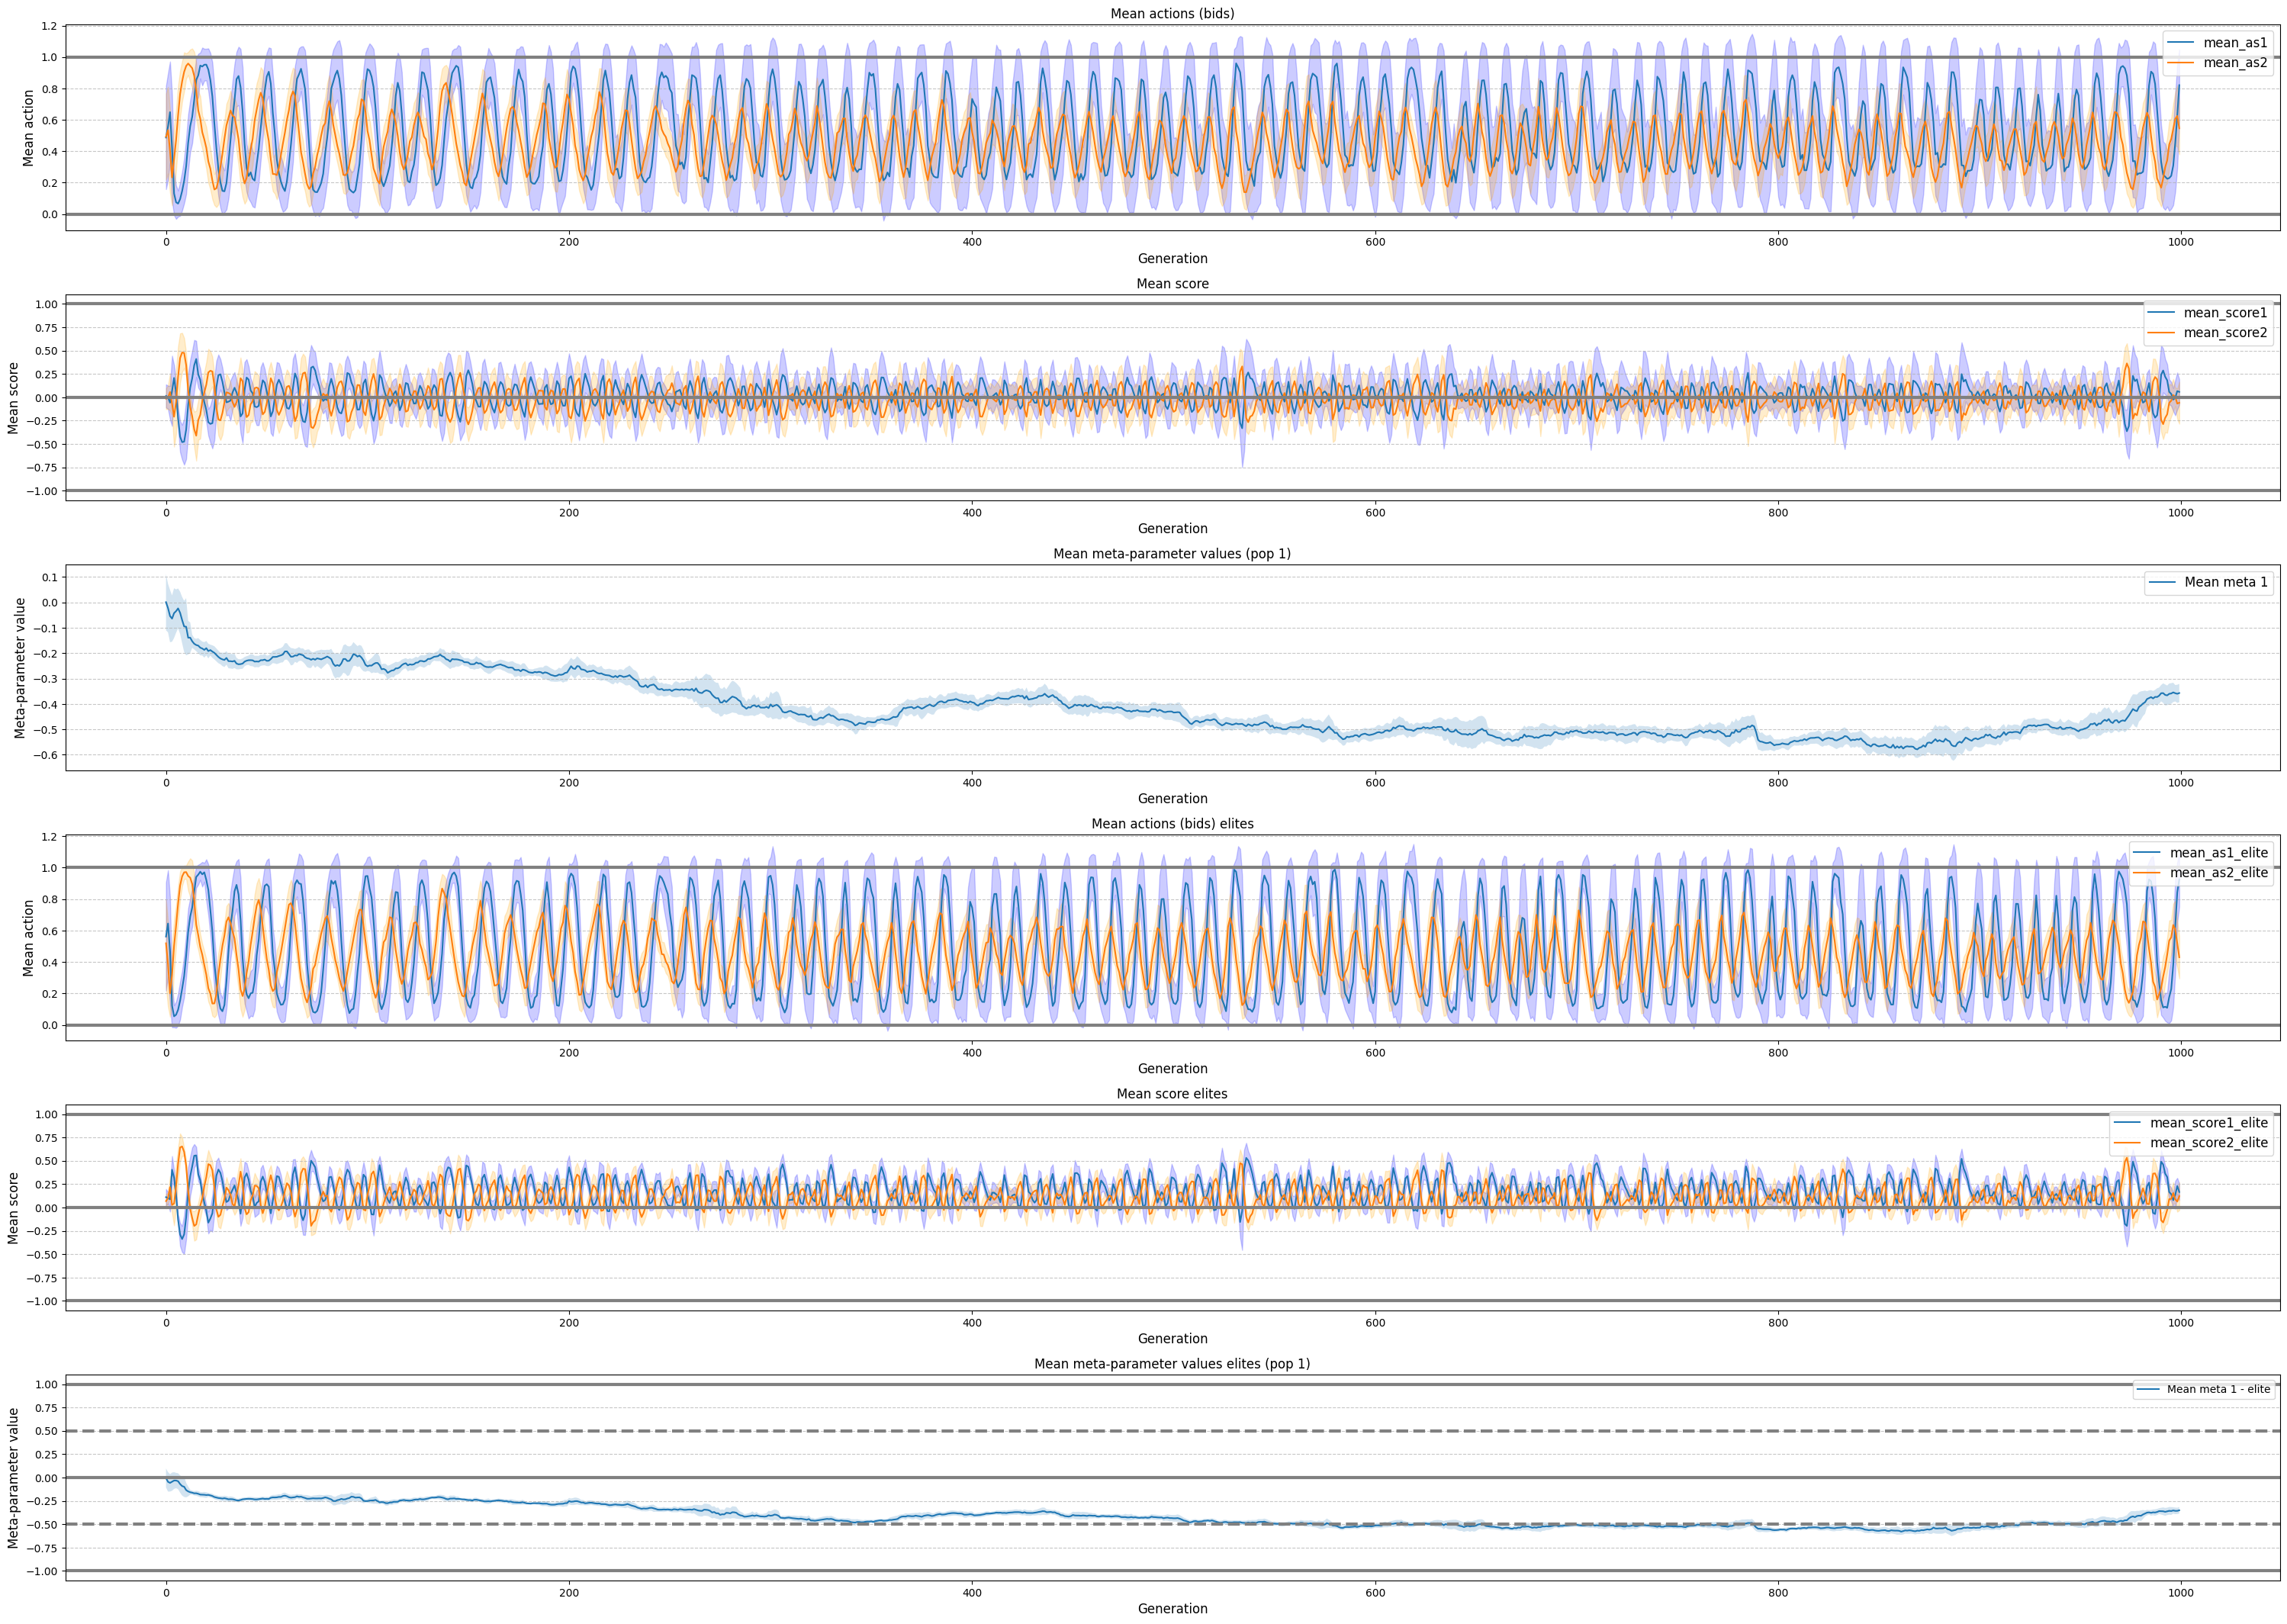

In [323]:
def plotter(final_t):
    plotcounter = 1
    plt.figure(figsize=(30, 28))
    
    # First subplot: Mean actions (bids)
    plt.subplot(8, 1, plotcounter)
    plt.plot(mean_as1[0:final_t])
    plt.plot(mean_as2[0:final_t])
    plt.fill_between(np.arange(final_t), mean_as1[0:final_t] - std_as1[0:final_t], 
                     mean_as1[0:final_t] + std_as1[0:final_t], color='blue', alpha=0.2)
    plt.fill_between(np.arange(final_t), mean_as2[0:final_t] - std_as2[0:final_t], 
                     mean_as2[0:final_t] + std_as2[0:final_t], color='orange', alpha=0.2)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean actions (bids)", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean action", fontsize=12)
    plt.legend(["mean_as1", "mean_as2"], fontsize=12)
    
    # Second subplot: Mean score
    plotcounter += 1
    plt.subplot(8, 1, plotcounter)
    plt.plot(mean_scores1[0:final_t])
    plt.plot(mean_scores2[0:final_t])
    plt.fill_between(np.arange(final_t), mean_scores1[0:final_t] - std_scores1[0:final_t], 
                     mean_scores1[0:final_t] + std_scores1[0:final_t], color='blue', alpha=0.2)
    plt.fill_between(np.arange(final_t), mean_scores2[0:final_t] - std_scores2[0:final_t], 
                     mean_scores2[0:final_t] + std_scores2[0:final_t], color='orange', alpha=0.2)
    plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean score", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean score", fontsize=12)
    plt.legend(["mean_score1", "mean_score2"], fontsize=12)

    # Third subplot: Mean meta-parameter values (pop 1)
    if mean_meta_1s.ndim > 1:
        plotcounter += 1
        plt.subplot(8, 1, plotcounter)
        for i in range(mean_meta_1s.shape[1]):
            plt.plot(mean_meta_1s[0:final_t][:, i], label="Mean meta {}".format(i+1))
            plt.fill_between(np.arange(final_t), mean_meta_1s[0:final_t][:, i] - std_meta_1s[0:final_t][:, i], 
                            mean_meta_1s[0:final_t][:, i] + std_meta_1s[0:final_t][:, i], alpha=0.2)
        #plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
        #plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
        #plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
        #plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
        #plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.title("Mean meta-parameter values (pop 1)", fontsize=12)
        plt.xlabel("Generation", fontsize=12)
        plt.ylabel("Meta-parameter value", fontsize=12)
        plt.legend(fontsize=12)

    # Fourth subplot: Mean meta-parameter values (pop 2)
    if mean_meta_2s.ndim > 1:  
        plotcounter += 1  
        plt.subplot(8, 1, plotcounter)
        for i in range(mean_meta_2s.shape[1]):
            plt.plot(mean_meta_2s[0:final_t][:,i], label="Mean meta {}".format(i+1))
            plt.fill_between(np.arange(final_t), mean_meta_2s[0:final_t][:,i] - std_meta_2s[0:final_t][:,i], 
                             mean_meta_2s[0:final_t][:,i] + std_meta_2s[0:final_t][:,i], alpha=0.2)
        #plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
        #plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
        #plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
        #plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
        #plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.title("Mean meta-parameter values (pop 2)", fontsize=12)
        plt.xlabel("Generation", fontsize=12)
        plt.ylabel("Meta-parameter value", fontsize=12)
        plt.legend(fontsize=12)

    # Fifth subplot: Mean actions (bids) elites
    plotcounter += 1  
    plt.subplot(8, 1, plotcounter)
    plt.plot(mean_as1_elite[0:final_t])
    plt.plot(mean_as2_elite[0:final_t])
    plt.fill_between(np.arange(final_t), mean_as1_elite[0:final_t] - std_as1_elite[0:final_t], 
                     mean_as1_elite[0:final_t] + std_as1_elite[0:final_t], color='blue', alpha=0.2)
    plt.fill_between(np.arange(final_t), mean_as2_elite[0:final_t] - std_as2_elite[0:final_t], 
                     mean_as2_elite[0:final_t] + std_as2_elite[0:final_t], color='orange', alpha=0.2)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean actions (bids) elites", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean action", fontsize=12)
    plt.legend(["mean_as1_elite", "mean_as2_elite"], fontsize=12)

    # Sixth subplot: Mean score elites
    plotcounter += 1  
    plt.subplot(8, 1, plotcounter)
    plt.plot(mean_scores1_elite[0:final_t])
    plt.plot(mean_scores2_elite[0:final_t])
    plt.fill_between(np.arange(final_t), mean_scores1_elite[0:final_t] - std_scores1_elite[0:final_t], 
                     mean_scores1_elite[0:final_t] + std_scores1_elite[0:final_t], color='blue', alpha=0.2)
    plt.fill_between(np.arange(final_t), mean_scores2_elite[0:final_t] - std_scores2_elite[0:final_t], 
                     mean_scores2_elite[0:final_t] + std_scores2_elite[0:final_t], color='orange', alpha=0.2)
    plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
    plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title("Mean score elites", fontsize=12)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Mean score", fontsize=12)
    plt.legend(["mean_score1_elite", "mean_score2_elite"], fontsize=12)

    # Seventh subplot: Meta elites 1st pop
    if mean_meta_1s_elite.ndim > 1:    
        plotcounter += 1  
        plt.subplot(8, 1, plotcounter)
        for i in range(mean_meta_1s_elite.shape[1]):
            plt.plot(mean_meta_1s_elite[0:final_t][:,i],label="Mean meta {} - elite".format(i+1))
            plt.fill_between(np.arange(final_t), mean_meta_1s_elite[0:final_t][:,i] - std_meta_1s_elite[0:final_t][:,i], 
                            mean_meta_1s_elite[0:final_t][:,i] + std_meta_1s_elite[0:final_t][:,i], alpha=0.2)
        plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
        plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
        plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
        plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.title("Mean meta-parameter values elites (pop 1)", fontsize=12)
        plt.xlabel("Generation", fontsize=12)
        plt.ylabel("Meta-parameter value", fontsize=12)
        plt.legend()    

    # Eighth subplot: Meta elites 2nd pop
    if mean_meta_2s_elite.ndim > 1:    
        plotcounter += 1  
        plt.subplot(8, 1, plotcounter)
        for i in range(mean_meta_2s_elite.shape[1]):
            plt.plot(mean_meta_2s_elite[0:final_t][:,i],label="Mean meta {} - elite".format(i+1))
            plt.fill_between(np.arange(final_t), mean_meta_2s_elite[0:final_t][:,i] - std_meta_2s_elite[0:final_t][:,i], 
                            mean_meta_2s_elite[0:final_t][:,i] + std_meta_2s_elite[0:final_t][:,i], alpha=0.2)
        plt.axhline(y=-1, color='gray', linestyle='-', linewidth=3)
        plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=3)
        plt.axhline(y=0, color='gray', linestyle='-', linewidth=3)
        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=3)
        plt.axhline(y=1, color='gray', linestyle='-', linewidth=3)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.title("Mean meta-parameter values elites (pop 2)", fontsize=12)
        plt.xlabel("Generation", fontsize=12)
        plt.ylabel("Meta-parameter value", fontsize=12)
        plt.legend()  
    print("Mean score, 1st population: ", np.mean(mean_scores1))
    print("Mean score, 2nd population: ", np.mean(mean_scores2))
    print("Mean dispersion, 1st population: ", np.mean(std_as1))
    print("Mean dispersion, 2nd population: ", np.mean(std_as2))
    print("Mean elite score, 1st population: ", np.mean(mean_scores1_elite))
    print("Mean elite score, 2nd population: ", np.mean(mean_scores2_elite))
    plt.tight_layout()  
plotter(1000)